### DSCI 510 Fall 2020 Final Project

####  1. Name

Benjamin Gumser

####  2. Major gotchas

Admittedly, lots.

I could definitely improve the compartmentalization of the scraping functions. They look very clunky in my .py file. Before settling on storing all of my created objects in a single Globals class, the objects lived in several different dictionaries. Sometimes the functions referred to more than one of those dictionaries, so I couldn't build functions inside of the classes (with my Python capabilities). Looking at it now, I think I could tuck the scrapers inside of the globals class and make them more similar so they are easier to debug and reuse more overlapping code. Starting the entire project while using an sqlite database (not pythonic) was also a contributor to some of the code arrangement decisions.

Scraping all of the sites (over 950 valid ones) multiple times and making Google API queries takes a very long time. I used a time.sleep(1) to keep me within 100 queries per 100 seconds, but I know there are other libraries that I didn't have time to explore that will automatically adjust so API rates aren't exceeded.

I did not really use the Google Civic Information queries with the elected officials. I did incorporate them into my data model, but my efforts to use the Federal Election Commission API to check campaign finance records stalled out. I will readdress this in question 7 below.

####  3. Extra libraries

All imports are included in my Anaconda distribution. https://docs.anaconda.com/anaconda/packages/py3.8_win-64/

####  4. Other relevant matters

Scraping that many sites was a lot easier than I anticipated. However, getting usable data from those sites was incredibly challenging. Just getting geographic locations for each site took several different iterations of which sub-pages to scrape; this final version isn't great, but I think it is a decent compromise.

Each of the sites has a lot of "junk" articles created by algorithms. "Inventories in audio and video equipment industry fall 0.4 percent in September" and "Inventories in computer storage device manufacturing industry climb 1.7 percent in September" are just some of the gems that are out there. Sorting through this junk to find actual human influence without the natural language recognition and machine learning abilities that seasoned data scientists possess was challenging, but I eventually discovered (three days before the deadline) that some sites' Politics sections were very active, which became the foundation for most of this analysis.

####  5. What did you set out to study?

From milestone 1: "This project aims to explore the reach of these sites from Metric Media (over 900 of them), examine if they are more prevalent in certain demographic areas or areas with elected officials of a certain party."

I set out to study the reach and influence of the network of sites run by Metric Media. I intended to try to tie the activity of individual sites to the spending and party affiliation of political figures in the area, but I ran into difficulties discussed below.

Because of the challenges I faced trying to create quantifiable data from what were effectively newspaper clippings, I was unable to expand my analysis into demographic or political boundaries.

####  6. What were your conclusions?



####  7. What difficulties did you encounter?

Again, lots.

First, Metric Media is so focused on being a content mill that they have broken links on their main page (https://metricmedianews.com/). For example, https://southsacramentotoday.com/ should be https://southsactoday.com/. Sites frequently do not load or go down for a period of time. For my final scraping of the Politics section of each site, I ran my scraper over 10 times to finally get the html for each of those 950+ pages, as many just would not load the first (or eighth) time. I definitely used a VPN for this project.

Second, finding the geographic location of each site was a challenge. There is nothing in the About or Contact section that personally identifies where each site purports to exist. I initially started by scraping zip codes from the directory pages. Not all sites had usable directory pages, so I had to scrape multiple different sections of their directories. And then not all sites had usable sections in those directory pages, so I resorted to using the geographic location of the state, which is obviously a terrible placeholder. Eventually, I discovered that the business section often had zip codes, but if it didn't, I used the first part of the site name to query the Google Geolocation API. Some sites' locations are still off, but they are at least ballparked in the state.

Third, I did my best to try to use the elected official information from the Google Civic Info API to query the FEC spending database. The FEC has a unique identifier for each candidate depending on their elected position. Even if a query succeeded to find the candidate based on name alone, the finances for the candidate were often wildly inaccurate (sometimes in the billions). The OpenSecrets.org API (https://www.opensecrets.org/open-data/api-documentation) would have worked better except for the 200 calls per day limit. The FEC did not have a simple "how much many was spent in this district in this election" query. Ultimately, after not being able to reliably establish the correct elected official nor the correct finance information, I determined that no data was better than bad data.

Fourth, it was difficult to obtain quantifiable data from the sites. I initially scraped the main page of each site for articles. I further logged which of those articles had an author cited on the first page, but usually only two or three had an author listed, even though there were others that were clearly produced by real humans. When I found that the Politics sections of a few sites were particularly active, I wrote another scraper to see how active each site was. This formed the foundation of my visualization.

Fifth, the layout of the sites was such that I could not sort the data I wanted to see via GET or POST requests. They all feel like the static html sites I dabbled with in the early 2000s. Even clicking on a link to a specific author only shows the articles that the author has written on that individual site, which is not helpful when an author publishes on sites throughout the country.

Sixth, visualizing the data onto a map was challenging. Going from my first attempt with matplotlib and a .png map of the United States to my final Bokeh product took a lot of effort. I didn't know that Web Mercator was a geographic coordinate system until this project.

####  8. What skills did you wish you had while you were doing the project?

Using machine learning to classify articles as written by a human or by an algorithm would have been very helpful.

This was my first real use of visualization, as the class focused (rightfully) on the data and coding aspects.

####  9. What would you do next to expand the project?



### Data analysis section

I think this section might be important to include.

In [1]:
import pickle
# Pickle doesn't import the class definitions
from GUMSER_BENJAMIN_proj3 import Globals, Site, Article, State, Official, Author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, WheelZoomTool, PanTool, ResetTool, TapTool, SaveTool
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
import math
import datetime
from dateutil.parser import parse

The data from all of my scrapers is combined into one Globals object and serialized with pickle.

In [2]:
# Loads from the pickle
with open('data/g.pickle', 'rb') as p:
    g = pickle.load(p)
print(g)

967 Sites, 25801 Articles, 225 Authors, 451 Officials


In the class definitions, I created a function called 'to_dict' that returns values of several of the attributes of the class. It also performs calculations to convert traditional latitude and longitude to Web Mercator (mlat and mlng columns). Let's build a Pandas dataframe with which to work.

In [3]:
sites_df = pd.DataFrame.from_records([site.to_dict(g) for site in g.sites.values()])
sites_df.head()

,name,lat,lng,mlat,mlng,article_count,local_articles,local_written_articles,local_recent_politics
0,Auburn Times,32.390924,-85.879325,3.814736e+06,-9.560043e+06,29,27,0,0
1,Baldwin Times,30.922026,-87.736961,3.622627e+06,-9.766834e+06,30,27,0,0
2,Decatur Times,34.605925,-86.983342,4.110456e+06,-9.682941e+06,36,29,0,0
3,EC Alabama News,33.262093,-86.368087,3.930144e+06,-9.614451e+06,28,26,0,0
4,Gadsden Today,34.014264,-86.006639,4.030717e+06,-9.574215e+06,28,27,0,0


Let's see which sites have a lot of recent political articles.

In [53]:
sites_df.sort_values('local_recent_politics', ascending=False).head(20)

,name,lat,lng,mlat,mlng,article_count,local_articles,local_written_articles,local_recent_politics,post_election_articles
956,The Sconi,45.713685,-90.345701,5.734585e+06,-1.005724e+07,47,46,20,20,20
720,Keystone Today,39.891331,-75.163294,4.850163e+06,-8.367140e+06,49,48,20,20,20
227,Peach Tree Times,31.826389,-81.597500,3.740543e+06,-9.083392e+06,51,49,20,20,20
28,Grand Canyon Times,33.658732,-112.345698,3.983070e+06,-1.250627e+07,49,48,20,20,21
542,Enchantment State News,34.905734,-106.692506,4.151078e+06,-1.187696e+07,36,36,12,12,0
393,Great Lakes Wire,43.288352,-86.276799,5.355966e+06,-9.604289e+06,39,38,12,12,2
824,Lone Star Standard,35.137977,-101.883469,4.182648e+06,-1.134162e+07,47,46,13,12,1
507,Silver State Times,36.532746,-116.466598,4.374176e+06,-1.296500e+07,31,30,11,11,8
204,Sunshine Sentinel,26.060352,-80.292625,3.006558e+06,-8.938134e+06,33,32,11,11,2
600,Old North News,35.274826,-76.987348,4.201292e+06,-8.570192e+06,40,37,10,10,1


Well, that dataframe wasn't very visually appealing. Let's try a different approach.

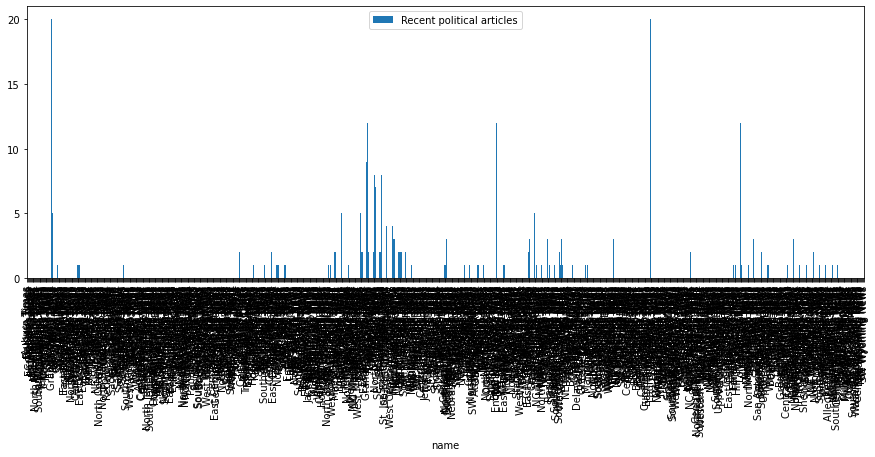

In [78]:
ax = sites_df.plot.bar(x='name', y='local_recent_politics', figsize=(15,5), yticks=[0, 5, 10, 15, 20])
ax.legend(['Recent politics articles']);

Also not helpful. 

In [54]:
# Map background
tile_provider = get_provider(CARTODBPOSITRON)
# Prevents pop-up windows by showing in notebook
output_notebook()
# Defines the hover functionality
hover = HoverTool(tooltips=[('Site name','@name'), ('Recent politics articles', '@local_recent_politics')])
zoom = WheelZoomTool()
tools = [hover, zoom, PanTool(), ResetTool(), TapTool(), SaveTool()]
# Sets initial map position via web mercator coordinates
p = figure(x_range=(-14026260, -7347086), y_range=(2753408, 6446276),
           x_axis_type="mercator", y_axis_type="mercator",
           plot_height=600, plot_width=950, tools=tools,
           title='Concentration of recent politics articles')
# Fixes default of no wheel zoom
p.toolbar.active_scroll = zoom

p.add_tile(tile_provider)
# Draw a small blue circle for each website
p.scatter(x='mlng', y='mlat', size=3, fill_color="blue", fill_alpha=0.2, line_color=None, source=sites_df)
# Draw a red circle depending on how many recent (after 1 September) political articles were written
p.scatter(x='mlng', y='mlat', size='local_recent_politics', fill_color='red', fill_alpha=0.9, line_color=None, source=sites_df)

show(p)

Loading BokehJS ...

Each of the sites' assumed location is a small blue dot, while the size of the red circles shows the number of recent political articles. There are clear concentrations in Michigan, Wisconsin, Pennsylvania, Georgia, Arizona, Minnesota -- all of which were closely contested states in the most recent presidential election. There are also numerous articles in Texas, New Mexico, Nevada, North Carolina, Florida, and Ohio. Again, all somewhat close states in the election.

Some sites clearly host the bulk of the articles in their respective states. If these were traditional local news organizations, the distribution would be different.

Let's perform some calculations on our once-pickled data. How many recent (after 1 September) political articles were featured on sites in each state?

In [56]:
# This will keep things smooth if this cell is run more than once
for state in g.states.values():
    setattr(state, 'local_recent_politics', 0)

for site in g.sites.values():
    # Each site is within a state
    state = site.state
    recent_article_count = len(site.local_recent_politics)
    g.states[state].local_recent_politics += recent_article_count

# Pulls a dictionary from each State as defined by State.to_dict()
# and converts to a dataframe
states_df = pd.DataFrame.from_records([state.to_dict(g) for state in g.states.values()])
states_df.head()

,name,lat,lng,mlat,mlng,local_recent_politics
0,Alaska,63.588753,-154.493062,9.246093e+06,-1.719809e+07,0
1,Alabama,32.318231,-86.902298,3.805156e+06,-9.673920e+06,1
2,Arkansas,35.201050,-91.831833,4.191237e+06,-1.022267e+07,1
3,Arizona,34.048928,-111.093731,4.035374e+06,-1.236690e+07,30
4,California,36.778261,-119.417932,4.408244e+06,-1.329354e+07,12


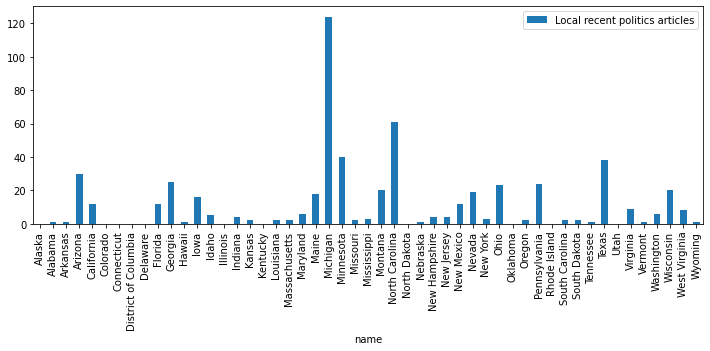

In [82]:
ax = states_df.plot.bar(x='name', y='local_recent_politics', figsize=(12,4))
ax.legend(['Local recent politics articles']);

This bar graph is better than our last one, but let's map it.

In [57]:
# Map background
tile_provider = get_provider(CARTODBPOSITRON)
# Prevents pop-up windows by showing in notebook
output_notebook()
# Defines the hover functionality
hover = HoverTool(tooltips=[('State','@name'), ('Recent politics articles', '@local_recent_politics')])
zoom = WheelZoomTool()
tools = [hover, zoom, PanTool(), ResetTool(), TapTool(), SaveTool()]
# Sets initial map position via web mercator coordinates
p = figure(x_range=(-14026260, -7347086), y_range=(2753408, 6446276),
           x_axis_type="mercator", y_axis_type="mercator",
           plot_height=600, plot_width=950, tools=tools,
           title='Concentration of recent political articles by state')
# Fixes default of no wheel zoom
p.toolbar.active_scroll = zoom

p.add_tile(tile_provider)
# Plots recent articles by state
p.scatter(x='mlng', y='mlat', size='local_recent_politics', fill_color='red', fill_alpha=0.6, line_color=None, source=states_df)

show(p)

Loading BokehJS ...

Michigan really was actively targeted by Metric Media, dwarfing all other states. North Carolina, surprisingly, is the next most active state. But some of these articles were before the election. Let's sort through the articles dated after the election.

In [83]:
for state in g.states.values():
    # Resets old calculations
    setattr(state, 'post_election_articles', 0)

for site in g.sites.values():
    # Resets old calculations
    setattr(site, 'post_election_articles', 0)
    # state is a State object
    state = g.states[site.state]
    for article in site.article_set:
        # article is an Article object
        article = g.articles[article]      
        if article.date == None:
            # Some articles don't have dates
            continue
        # If the article date is after the election
        if parse(article.date).date() >= datetime.date(2020, 11, 3):
            site.post_election_articles += 1
            state.post_election_articles += 1
            
# Add another column to the dataframe
sites_df['post_election_articles'] = pd.Series(site.post_election_articles for site in g.sites.values())
sites_df.head()

,name,lat,lng,mlat,mlng,article_count,local_articles,local_written_articles,local_recent_politics,post_election_articles
0,Auburn Times,32.390924,-85.879325,3.814736e+06,-9.560043e+06,29,27,0,0,0
1,Baldwin Times,30.922026,-87.736961,3.622627e+06,-9.766834e+06,30,27,0,0,0
2,Decatur Times,34.605925,-86.983342,4.110456e+06,-9.682941e+06,36,29,0,0,0
3,EC Alabama News,33.262093,-86.368087,3.930144e+06,-9.614451e+06,28,26,0,0,0
4,Gadsden Today,34.014264,-86.006639,4.030717e+06,-9.574215e+06,28,27,0,0,0


In [85]:
# And add another column here
states_df['post_election_articles'] = pd.Series(state.post_election_articles for state in g.states.values())
states_df.head()

,name,lat,lng,mlat,mlng,local_recent_politics,post_election_articles
0,Alaska,63.588753,-154.493062,9.246093e+06,-1.719809e+07,0,0
1,Alabama,32.318231,-86.902298,3.805156e+06,-9.673920e+06,1,0
2,Arkansas,35.201050,-91.831833,4.191237e+06,-1.022267e+07,1,0
3,Arizona,34.048928,-111.093731,4.035374e+06,-1.236690e+07,30,28
4,California,36.778261,-119.417932,4.408244e+06,-1.329354e+07,12,6


Let's map this by site.

In [91]:
# Map background
tile_provider = get_provider(CARTODBPOSITRON)
# Prevents pop-up windows by showing in notebook
output_notebook()
# Defines the hover functionality
hover = HoverTool(tooltips=[('Site name','@name'), ('Post election articles', '@post_election_articles')])
zoom = WheelZoomTool()
tools = [hover, zoom, PanTool(), ResetTool(), TapTool(), SaveTool()]
# Sets initial map position via web mercator coordinates
p = figure(x_range=(-14026260, -7347086), y_range=(2753408, 6446276),
           x_axis_type="mercator", y_axis_type="mercator",
           plot_height=600, plot_width=950, tools=tools,
           title='Concentration of post election articles')
# Fixes default of no wheel zoom
p.toolbar.active_scroll = zoom

p.add_tile(tile_provider)
p.scatter(x='mlng', y='mlat', size='local_recent_politics', fill_color='blue', fill_alpha=0.3, line_color=None, source=sites_df)
p.scatter(x='mlng', y='mlat', size='post_election_articles', fill_color='red', fill_alpha=0.9, line_color=None, source=sites_df)

show(p)

Loading BokehJS ...

The blue circles represent the same data from our previous charts, with the red being post-election articles. The difference between the red and the blue represents the change from before the election to after the election.

For example, the blue circle in southern Florida shows that there were a number of articles published before the election, but only a couple published after. In Georgia and Arizona, the circles are roughly the same size, meaning that the majority of the articles are fresh after the election.

In [90]:
# Map background
tile_provider = get_provider(CARTODBPOSITRON)
# Prevents pop-up windows by showing in notebook
output_notebook()
# Defines the hover functionality
hover = HoverTool(tooltips=[('Site name','@name'), ('Post election articles', '@post_election_articles'), 
                            ('Recent politics articles', '@local_recent_politics')])
zoom = WheelZoomTool()
tools = [hover, zoom, PanTool(), ResetTool(), TapTool(), SaveTool()]
# Sets initial map position via web mercator coordinates
p = figure(x_range=(-14026260, -7347086), y_range=(2753408, 6446276),
           x_axis_type="mercator", y_axis_type="mercator",
           plot_height=600, plot_width=950, tools=tools,
           title='Concentration of post election articles')
# Fixes default of no wheel zoom
p.toolbar.active_scroll = zoom

p.add_tile(tile_provider)
p.scatter(x='mlng', y='mlat', size='local_recent_politics', fill_color='blue', fill_alpha=0.3, line_color=None, source=states_df)
p.scatter(x='mlng', y='mlat', size='post_election_articles', fill_color='red', fill_alpha=0.9, line_color=None, source=states_df)

show(p)

Loading BokehJS ...

To me, the most telling datapoint on the above chart is that in North Carolina. There were numerous articles published before the election, but very few after. North Carolina was called very early after the election for the incumbent candidate.